## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'gold'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['close', 'high', 'low', 'open', 'rsi14', 'sma14']

## Converting TAG Name Format
* After checking all the Tag Names from the Gold Price dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names Close, rsi14, sma14.

In [5]:
# Set the desired tag names
tags = ['close', 'rsi14', 'sma14']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'close','rsi14','sma14'


## Load Gold Price Dataset
* Load the data using tag names

In [6]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Move 'value' column to the end
    df['close'] = df.pop('close')
        
    return df

In [7]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    target = 'time'
    
    # Load the data
    df = pd.read_csv(f"http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?target={target}&table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}")
    
    # Create a dummy value column for resampling
    df['value'] = 0
    
    # Perform resampling
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    # Determine resampling units based on the data and perform resampling
    df = df.resample('1T').mean()
    
    # Remove missing values
    df = df.dropna()
    
    # Remove the dummy value column
    df = df.drop(['value'], axis=1)
    
    return df

In [8]:
# Time update function
# Update start and end times based on batch size
def update_time(time_df, start_time, batch_size):
    
    # Calculate how many data points need to be loaded
    time = batch_size - 1
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time 
    end_time_ = str(time_df.index[index_now + time] + timedelta(seconds=1))
    
    # Set the index number for the next start time
    index_next = index_now + time + 1
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

In [9]:
# Function to calculate the maximum and minimum values for selected tag names
def set_minmax_value(table, name, start_time_train, end_time_train):
    
    # URL encoding
    start = quote(start_time_train)
    end = quote(end_time_train)
    
    # Load Min, Max data
    df_ = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-scale.tql?table={table}&name={name}&start={start}&end={end}')
    
    # Set Min, Max values
    Min = df_.iloc[:,1:-1].T
    Max = df_.iloc[:,2:].T
    
    return Min, Max 

## Data Preprocessing

* 1 MinMax Scaling

### 1. Min-Max Scaling Setup
* Set up a Min-Max Scaler that uses the maximum and minimum values, as the entire dataset is not loaded due to the process concept.

In [10]:
# Definition of the MinMaxScaler class
class MinMaxScaler_custom:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    # Set scale values based on the specified parameters
    def transform(self, X, min_values, max_values):
        X = np.array(X)
        self.min_ = np.array(min_values)
        self.max_ = np.array(max_values)
        
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        scale = (self.max_ - self.min_)
        if np.any(scale == 0):
            raise ValueError("Min and Max values are the same, resulting in a scale of 0.")
        
        return (X - self.min_) / scale
    
    # Normalize data based on calculated scale values
    def fit_transform(self, X, min_values, max_values):
        """Set parameters and then transform X"""
        return self.transform(X, min_values, max_values)

    # Inverse the normalized data back to original values
    def inverse_transform(self, X_scaled):
        """Inverse the transformation and return original values"""
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        X_scaled = np.array(X_scaled)
        scale = (self.max_ - self.min_)
        
        return X_scaled * scale + self.min_

## Model Configuration
* Using Temporal Convolutional Network(TCN) model.

In [11]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation  # Set padding based on kernel size and dilation
        # First 1D convolution layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        # Second 1D convolution layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Construct the sequence of layers
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        
        # Downsample for residual connection if needed
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        # Trim the output to match the input size (fixing size mismatch due to padding)
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, 
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)  # Output layer for regression tasks

    def forward(self, x):
        x = self.network(x)
        x = x[:, :, -1]  # Use the output from the last time step
        return self.linear(x)

In [12]:
# Model configuration parameters
input_channels = 1
hidden_channels = [25, 50, 100] 
kernel_size = 3
dropout = 0.2

# Learning rate
learning_rate = 0.001

# Initialize the model, loss, and optimizer
model = TCN(num_inputs=input_channels, num_channels=hidden_channels, kernel_size=kernel_size, dropout=dropout).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(25, 50, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(4,), di

## Model Training

In [13]:
# Model training function
def train(table, name, timeformat, model, batch_size, epochs, scaler_data, scaler_target, Min, Max, time_df_train):
    
    # Initialize training loss
    train_loss = []

    # Initialize best loss value
    best_Loss = np.inf

    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])
        
        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next = update_time(time_df_train, start_time_, batch_size)
        
            # Load batch data
            data = data_load(table, name, start_time_, end_time_, timeformat)
            
            # Apply MinMax scaler
            data_scaled = scaler_data.fit_transform(data.iloc[:, :-1], Min.iloc[:,1:], Max.iloc[:,1:])
            target_scaled = scaler_target.fit_transform(data.iloc[:, -1:], Min.iloc[:,:1], Max.iloc[:,:1])
            
            # Set up the DataFrame
            data = pd.DataFrame(data_scaled)
            data['Close'] = target_scaled
            
            # Print if the loaded data is empty
            if len(data) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(data) == batch_size:
                
                # Check total batch count
                total_step += 1
                
                # Convert data to numpy arrays
                input_data = np.array(data.iloc[:, :-1])
                input_target = np.array(data.iloc[:, -1:])
                
                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                input_target = torch.tensor(input_target, dtype=torch.float32).to(device).float()
                
                # Optimize the optimizer
                optimizer.zero_grad()
                
                # Input to the model
                outputs = model(input_data.unsqueeze(1))
        
                # Calculate loss
                loss = criterion(outputs, input_target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                data = []
                
            # Set the next start time
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + batch_size >= len(time_df_train):
                break
            
        # Print training loss
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')
        
        # Save the model if it has the best loss
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Gold_Price_New_Batch.pt')
            print('Model saved')
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
        
    return model

In [14]:
########################################### Training Parameter Settings ################################################
# Set the tag table name
table = 'gold'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time_train = '2010-01-03 18:00:00'
# Set the data end time
end_time_train = '2023-01-01 00:00:00'
# Set batch size
batch_size = 1024
# Set number of epochs
epochs = trange(100, desc='training')
# Set Min, Max value 
Min, Max = set_minmax_value(table, name, start_time_train, end_time_train)
# Set scalers
scaler_data = MinMaxScaler_custom()
scaler_target = MinMaxScaler_custom()
# Load training time list 
time_df_train = time_data_load(table, name, quote(start_time_train), quote(end_time_train), timeformat)
########################################### Proceed with training ################################################
train(table, name, timeformat, model, batch_size, epochs, scaler_data, scaler_target, Min, Max, time_df_train)

training:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,



train loss: 0.0021108625585439748
Model saved

train loss: 0.0018561404275858357
Model saved

train loss: 0.0014531978874829689
Model saved

train loss: 0.001162800188348376
Model saved

train loss: 0.0009602737637905252
Model saved

train loss: 0.0008148879399258332
Model saved

train loss: 0.0007063228512863083
Model saved

train loss: 0.000631126215000706
Model saved

train loss: 0.0005765727017528106
Model saved

train loss: 0.0005306180443342861
Model saved

train loss: 0.0004923033211081504
Model saved

train loss: 0.00046165818990583345
Model saved

train loss: 0.00043585619414555964
Model saved

train loss: 0.00041332737607836513
Model saved

train loss: 0.0003934610552086027
Model saved

train loss: 0.0003757822386594379
Model saved

train loss: 0.00035996564311505
Model saved

train loss: 0.0003458528627976004
Model saved

train loss: 0.00033311029613095717
Model saved

train loss: 0.0003214252468154623
Model saved

train loss: 0.0003107306148419259
Model saved

train loss: 

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(25, 50, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(4,), di

## Model Testing

In [15]:
# Model testing function  
def test(table, name, timeformat, model, batch_size, scaler_data, scaler_target, Min, Max, time_df_test):
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
            
        # Set the initial start time
        start_time_t = str(time_df_test.index[0])
        
        # Set the end time
        end_time_test = str(time_df_test.index[-1])
        
        # Use a while loop to call data 
        while start_time_t < end_time_test:
            
            # Set the time for loading data based on the batch size
            start_time_t, end_time_t, next_start_time_t, index_next_t = update_time(time_df_test, start_time_t, batch_size)
        
            # Load batch data
            data_t = data_load(table, name, start_time_t, end_time_t, timeformat)
            
            # Apply MinMax scaler
            data_scaled = scaler_data.fit_transform(data_t.iloc[:,:-1], Min.iloc[:,1:], Max.iloc[:,1:])
            target_scaled = scaler_target.fit_transform(data_t.iloc[:,-1:], Min.iloc[:,:1], Max.iloc[:,:1])
            
            # Set the DataFrame
            data_t = pd.DataFrame(data_scaled)
            data_t['target'] = target_scaled
            
            # Print if the loaded data is empty 
            if len(data_t) == 0:
                print("No data available.")
            
            # Move to the next batch if the data size matches the batch size
            if len(data_t) == batch_size:
                
                # Convert data to numpy arrays
                input_data_t = np.array(data_t.iloc[:, :-1])
                input_target_t = np.array(data_t.iloc[:, -1:])

                # Convert data to Tensor
                input_data_t = torch.tensor(input_data_t, dtype=torch.float32).to(device).float()
                input_target_t = torch.tensor(input_target_t, dtype=torch.float32).to(device).float()
                
                # Model input
                outputs_t = model(input_data_t.unsqueeze(1))
                
                output_test.append(outputs_t)
                output_target.append(input_target_t)
                
                # Reset the batch
                data_t = []

            # Set the next start time    
            start_time_t = unquote(next_start_time_t)
            
            # Prevent loading beyond the last time
            if index_next_t + batch_size >= len(time_df_test):
                break
        
        # Combine the tensors into one
        combined_tensor_target = torch.cat(output_target, dim=0)
        combined_tensor_pred = torch.cat(output_test, dim=0)

        # Use only the last values of the window
        last_values_target = combined_tensor_target[:, -1].cpu()
        last_values_pred = combined_tensor_pred.cpu()

        # Inverse transform using MinMaxScaler 
        real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
        real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1)) 
        
        return real_values, real_pred_values

In [16]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/Gold_Price_New_Batch.pt')
# Set the start time for the test data
start_time_test = '2023-01-01 00:00:00'
# Set the end time for the test data
end_time_test = '2024-01-01 00:00:00'
# Load the test time list
time_df_test = time_data_load(table, name, quote(start_time_test), quote(end_time_test), timeformat)

######################################## Proceed with testing #############################################
real_values, real_pred_values = test(table, name, timeformat, model, batch_size, scaler_data, scaler_target, Min, Max, time_df_test)

## Model Performance Evaluation

In [17]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 2.7210259416119538
R² Score: 0.9992227237636866


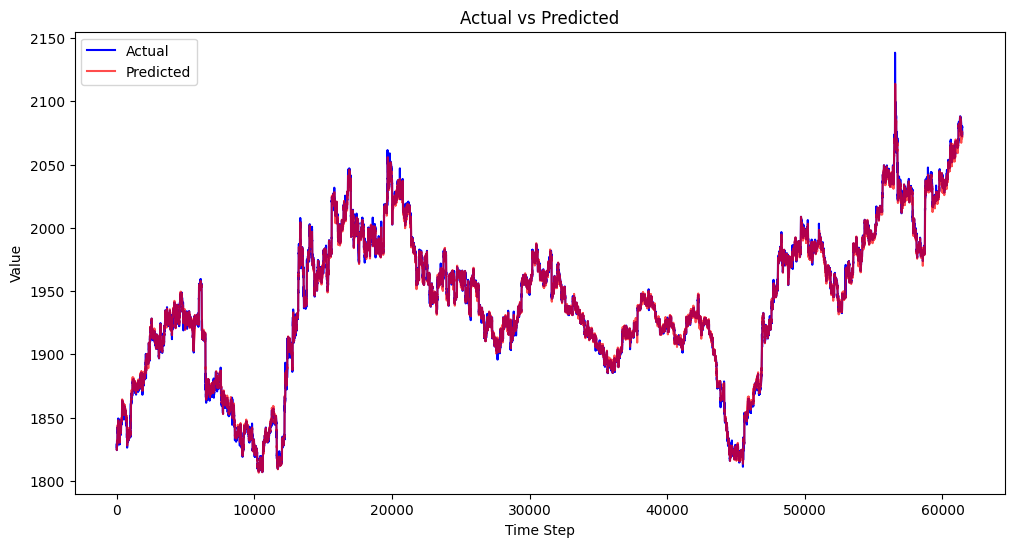

In [18]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()